In [32]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.optim import Adam
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from open_clip import create_model_and_transforms
from PIL import Image
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.gleu_score import sentence_gleu
from datasets import load_metric
from tqdm import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ninja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ninja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [81]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder_model_name='hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224', 
                 gpt2_model_name='gpt2', projection_dim=512):
        super(ImageCaptioningModel, self).__init__()
        
        # Load Encoder model and its tokenizer
        self.encoder_model, self.preprocess_train, self.preprocess_val = create_model_and_transforms(
            encoder_model_name, pretrained_hf=True
        )
        
        # Get the encoder output size by passing a dummy input through the encoder
        dummy_input = torch.rand(1, 3, 224, 224)  # Assuming the model input size is 224x224
        with torch.no_grad():
            dummy_output = self.encoder_model.encode_image(dummy_input)
        self.encoder_output_dim = dummy_output.shape[1]  # Use the embedding dimension from the dummy output
        
        # GPT-2 Decoder model
        self.gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_name)
        self.gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)

        # Projection layer to match embedding sizes
        self.image_embeddings_projected = nn.Linear(self.encoder_output_dim, projection_dim)
    
    def forward(self, images, input_ids, attention_mask):
        # Extract image embeddings
        image_embeddings = self.encoder_model.encode_image(images)
        image_embeddings_projected = self.image_embeddings_projected(image_embeddings)
        # Get GPT-2 outputs using the provided input_ids and attention_mask
        logits = self.gpt2_model(input_ids=input_ids, attention_mask=attention_mask).logits
        return logits
    
    def preprocess_image(self, image_path):
        """
        Preprocess an image for input to the model.
        """
        image = Image.open(image_path).convert('RGB')
        image_tensor = self.preprocess_val(image).unsqueeze(0)  # Preprocess image and add batch dimension
        return image_tensor

    def tokenize_caption(self, caption):
        """
        Tokenize a caption using GPT-2 tokenizer.
        """
        return self.gpt2_tokenizer.encode(caption, return_tensors='pt')

    def decode_caption(self, caption_tokens):
        """
        Decode caption tokens to text.
        """
        return self.gpt2_tokenizer.decode(caption_tokens, skip_special_tokens=True)
        
    def generate_caption_for_image(self, image_tensor):
        """
        Generate a caption for a given image tensor.
        """
        # Switch to evaluation mode
        self.eval()
        
        # Move image to the appropriate device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        image_tensor = image_tensor.to(device)
    
        # Disable gradient computation for inference
        with torch.no_grad():
            # Extract image embeddings using the encoder
            image_embeddings = self.encoder_model.encode_image(image_tensor)
            image_embeddings_projected = self.image_embeddings_projected(image_embeddings)
            
            # Generate caption using the GPT-2 decoder
            generated_ids = self.gpt2_model.generate(
                input_ids=None,                     # No input IDs for generation
                inputs_embeds=image_embeddings_projected,  # Use image embeddings as input
                max_length=50,                      # Maximum length for the generated caption
                num_beams=5,                        # Beam search for better captions
                repetition_penalty=2.5,             # Penalize repeated tokens
                length_penalty=1.0,                 # Penalize too short/long captions
                early_stopping=True
            )
    
            # Decode the generated token IDs into text
            generated_caption = self.gpt2_tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        
        return generated_caption

In [3]:
class ROCODataset(Dataset):
    def __init__(self, caption_file, image_folder, model):
        self.captions = pd.read_csv(caption_file)
        self.image_folder = image_folder
        self.preprocess = model.preprocess_train
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

        # Assign a padding token
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token  # or you can set a new token with add_special_tokens

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        caption = self.captions.iloc[idx]['Caption']
        image_id = self.captions.iloc[idx]['ID']
        image_path = os.path.join(self.image_folder, image_id + '.jpg')

        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.preprocess(image)
        # Tokenize the caption
        caption_tokens = self.tokenizer(caption, return_tensors='pt', padding=True, truncation=True)

        return image_tensor, caption_tokens['input_ids'].squeeze(0), caption_tokens['attention_mask'].squeeze(0)


In [4]:
def custom_collate_fn(batch):
    images, captions, attention_masks = zip(*batch)
    
    # Stack images (they are all the same size)
    images = torch.stack(images)
    
    # Pad captions and attention masks
    captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=0)
    attention_masks = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)
    
    return images, captions, attention_masks


In [5]:
import time

def train_model_mixed_precision(model, dataloader, epochs=5, lr=1e-4, accumulation_steps=4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    scaler = torch.amp.GradScaler()
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        running_loss = 0.0
        epoch_start_time = time.time()

        for i, (image_tensor, inputs, attention_mask) in enumerate(dataloader):
            image_tensor = image_tensor.to(device)
            inputs = inputs.to(device)
            attention_mask = attention_mask.to(device)

            # Normalize the gradients by the number of accumulation steps
            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                logits = model(image_tensor, inputs, attention_mask)
                loss = loss_fn(logits.view(-1, logits.size(-1)), inputs.view(-1))

            # Scale the loss for mixed precision
            loss = loss / accumulation_steps
            scaler.scale(loss).backward()

            # Update weights after specified number of steps
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Reset gradients for the next accumulation

            running_loss += loss.item() * accumulation_steps  # Accumulate loss

            # Measure time per batch
            if i % 10 == 0:  # Print every 10 batches
                print(f"Batch {i}, Loss: {loss.item()}")

        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(dataloader)}, Duration: {epoch_duration:.2f} seconds")

In [6]:
# File paths
train_caption_file = "../Datasets/ROCO2/train_captions.csv"
train_image_folder = "../Datasets/ROCO2/train_images/train/"
test_caption_file = "../Datasets/ROCO2/test_captions.csv"
test_image_folder = "../Datasets/ROCO2/test_images/test/"

# Initialize the model (use the BiomedCLIP model as encoder)
model = ImageCaptioningModel(encoder_model_name='hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

# Create datasets for train and test
train_dataset = ROCODataset(train_caption_file, train_image_folder, model)
test_dataset = ROCODataset(test_caption_file, test_image_folder, model)

# Create DataLoaders for train and test
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)

G:\anaconda3\envs\MEDCAT\Lib\site-packages\open_clip\factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_

In [7]:
# Train the model with the ROCO dataset
train_model_mixed_precision(model, train_loader, epochs=5)


G:\anaconda3\envs\MEDCAT\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


Batch 0, Loss: 2.479154586791992
Batch 10, Loss: 2.504966974258423
Batch 20, Loss: 2.300750732421875
Batch 30, Loss: 1.0652152299880981
Batch 40, Loss: 0.8089871406555176
Batch 50, Loss: 0.7406598329544067
Batch 60, Loss: 0.6939974427223206
Batch 70, Loss: 0.3410283923149109
Batch 80, Loss: 0.166847363114357
Batch 90, Loss: 0.04584067314863205
Batch 100, Loss: 0.026848753914237022
Batch 110, Loss: 0.03838247433304787
Batch 120, Loss: 0.025665391236543655
Batch 130, Loss: 0.008567225188016891
Batch 140, Loss: 0.0159713514149189
Batch 150, Loss: 0.01324827503412962
Batch 160, Loss: 0.022837158292531967
Batch 170, Loss: 0.0076666628010571
Batch 180, Loss: 0.012336456216871738
Batch 190, Loss: 0.012896337546408176
Batch 200, Loss: 0.006326641887426376
Batch 210, Loss: 0.010718663223087788
Batch 220, Loss: 0.008720191195607185
Batch 230, Loss: 0.008465439081192017
Batch 240, Loss: 0.004309150855988264
Batch 250, Loss: 0.0009736670181155205
Batch 260, Loss: 0.002450116677209735
Batch 270, Lo

Testing Measures:

In [14]:
def compute_bleu(predictions, references):
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        # Tokenize the predicted and reference captions
        pred_tokens = pred.split()
        ref_tokens = [ref.split()]  # BLEU expects a list of reference tokens
        bleu_score = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=SmoothingFunction().method1)
        bleu_scores.append(bleu_score)
    return sum(bleu_scores) / len(bleu_scores)  # Return the average BLEU score

In [15]:
def compute_gleu(predictions, references):
    gleu_scores = []
    for pred, ref in zip(predictions, references):
        # Tokenize the predicted and reference captions
        pred_tokens = pred.split()
        ref_tokens = [ref.split()]  # GLEU expects a list of reference tokens
        gleu_score = sentence_gleu(ref_tokens, pred_tokens)
        gleu_scores.append(gleu_score)
    return sum(gleu_scores) / len(gleu_scores)  # Return the average GLEU score

In [25]:
def compute_meteor(predictions, references):
    meteor_scores = []
    
    for pred, ref in zip(predictions, references):
        # Tokenize both the predicted and reference captions
        pred_tokens = nltk.word_tokenize(pred)
        ref_tokens = nltk.word_tokenize(ref)

        # METEOR expects tokenized sentences, so we pass the tokenized captions
        meteor = meteor_score([ref_tokens], pred_tokens)  # METEOR expects the reference to be a list of strings
        meteor_scores.append(meteor)
        
    return sum(meteor_scores) / len(meteor_scores)

In [29]:
def compute_rouge(predictions, references):
    rouge_metric = load_metric('rouge', trust_remote_code=True)
    rouge_scores = rouge_metric.compute(predictions=predictions, references=references)
    return {
        "rouge1": rouge_scores['rouge1'].mid.fmeasure,
        "rouge2": rouge_scores['rouge2'].mid.fmeasure,
        "rougeL": rouge_scores['rougeL'].mid.fmeasure
    }

In [34]:
def test_model(model, test_loader, metrics=['bleu', 'gleu', 'meteor', 'rouge'], num_examples=10, save_dir='generated_examples'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()  # Set the model to evaluation mode
    
    all_predictions = []
    all_references = []
    examples_shown = 0
    
    # Create directory to save examples
    os.makedirs(save_dir, exist_ok=True)
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for i, (image_tensor, inputs, attention_mask) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image_tensor = image_tensor.to(device)
            inputs = inputs.to(device)
            attention_mask = attention_mask.to(device)

            # Pass images through the model to generate captions
            logits = model(image_tensor, inputs, attention_mask)

            # Convert logits to actual predictions (token IDs)
            predicted_ids = torch.argmax(logits, dim=-1)

            # Convert token IDs back to text (captions)
            predicted_captions = model.gpt2_tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

            # Get reference captions (ground truth)
            reference_captions = model.gpt2_tokenizer.batch_decode(inputs, skip_special_tokens=True)

            all_predictions.extend(predicted_captions)
            all_references.extend(reference_captions)
            
            # Show and save a few examples of predictions, references, and corresponding images
            if examples_shown < num_examples:
                for idx, (pred_caption, ref_caption, img_tensor) in enumerate(zip(predicted_captions, reference_captions, image_tensor)):
                    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy for displaying
                    
                    # Display the image and captions
                    plt.figure(figsize=(8, 6))
                    plt.imshow(img_np)
                    plt.title(f"Generated: {pred_caption}\nReference: {ref_caption}")
                    plt.axis('off')
                    
                    # Save the image with captions
                    save_path = os.path.join(save_dir, f"example_{examples_shown + 1}.png")
                    plt.savefig(save_path)
                    plt.show()  # Show the image inline
                    
                    examples_shown += 1
                    if examples_shown >= num_examples:
                        break

    # Compute evaluation metrics
    results = {}
    if 'bleu' in metrics:
        results['BLEU'] = compute_bleu(all_predictions, all_references)
    if 'gleu' in metrics:
        results['GLEU'] = compute_gleu(all_predictions, all_references)
    if 'meteor' in metrics:
        results['METEOR'] = compute_meteor(all_predictions, all_references)
    if 'rouge' in metrics:
        results['ROUGE'] = compute_rouge(all_predictions, all_references)
    
    print("Test Results:", results)
    return results

  0%|                                                                                                                                                                                                                                                                                         | 0/1247 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


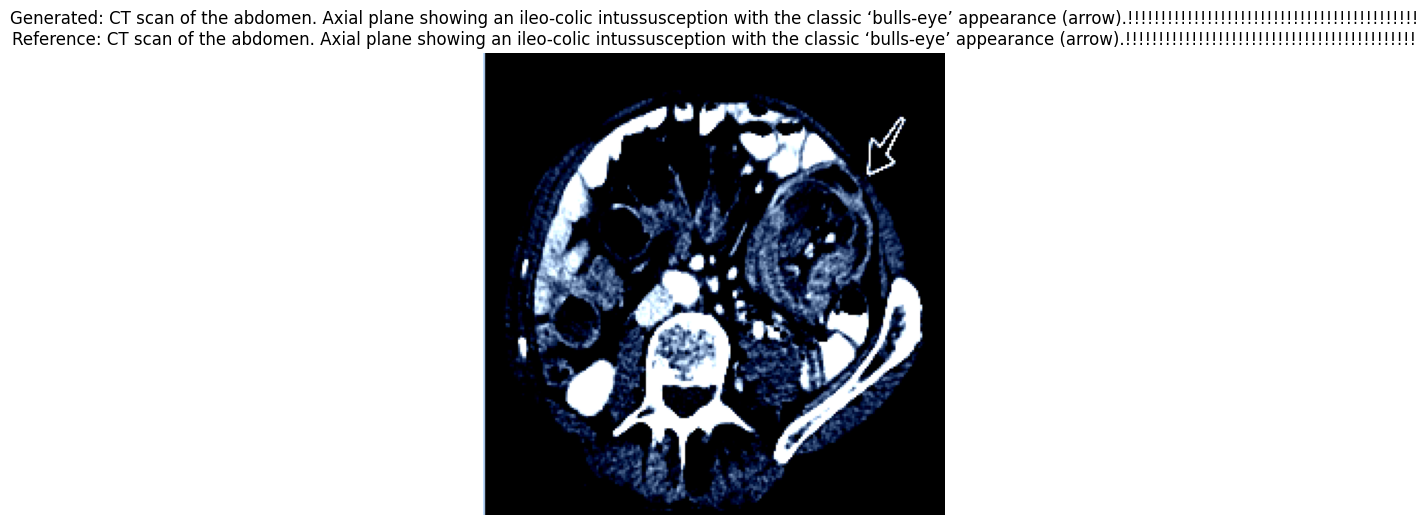

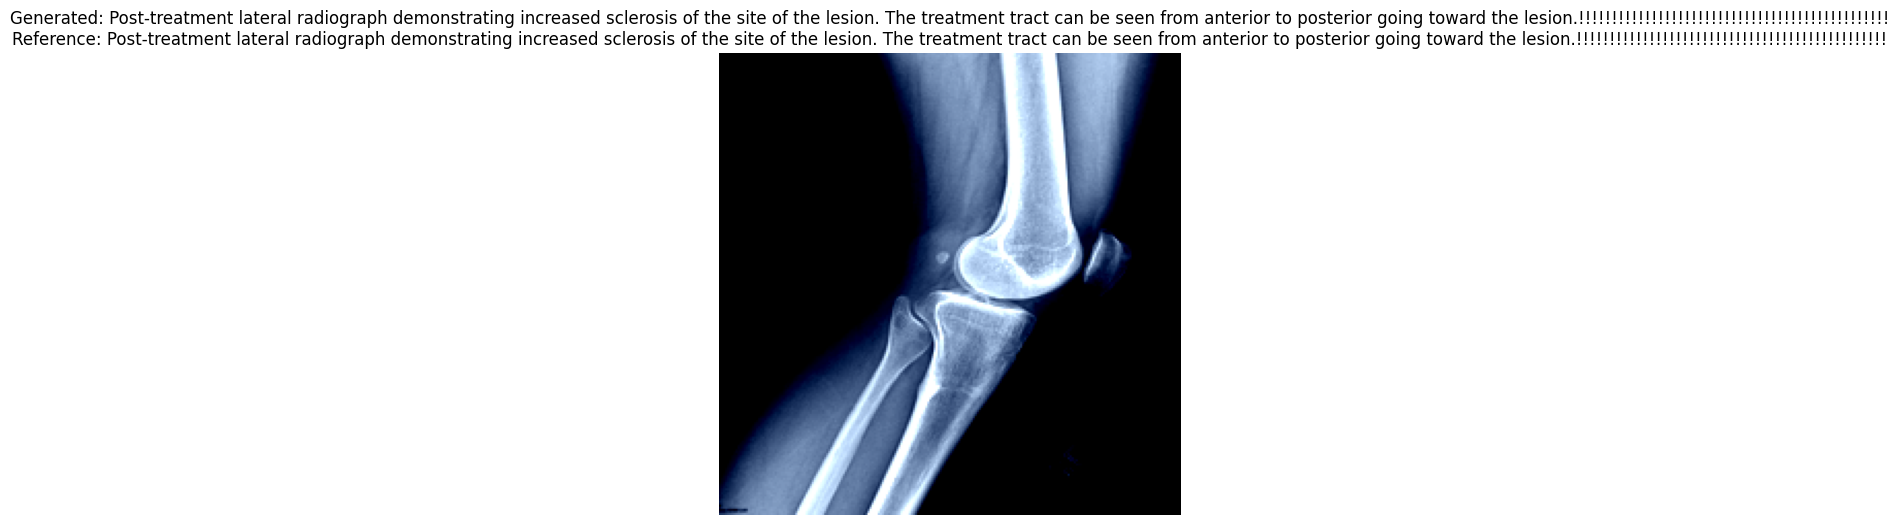

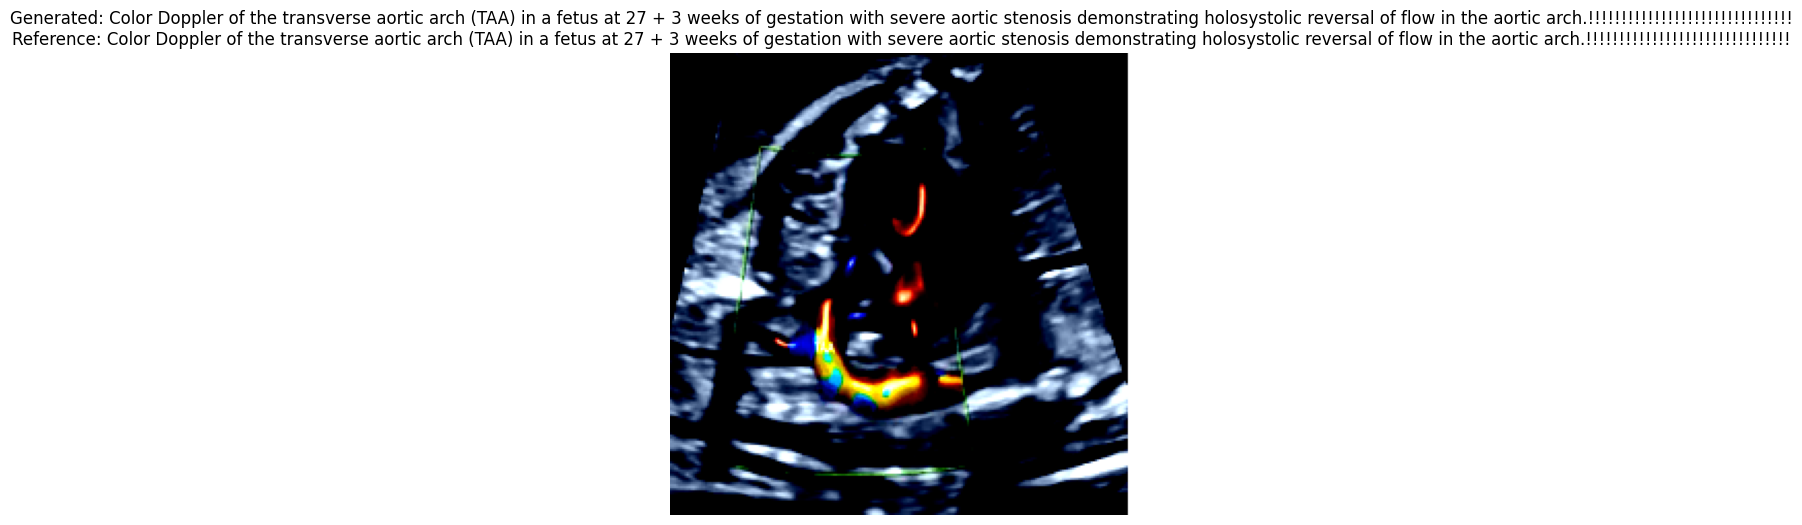

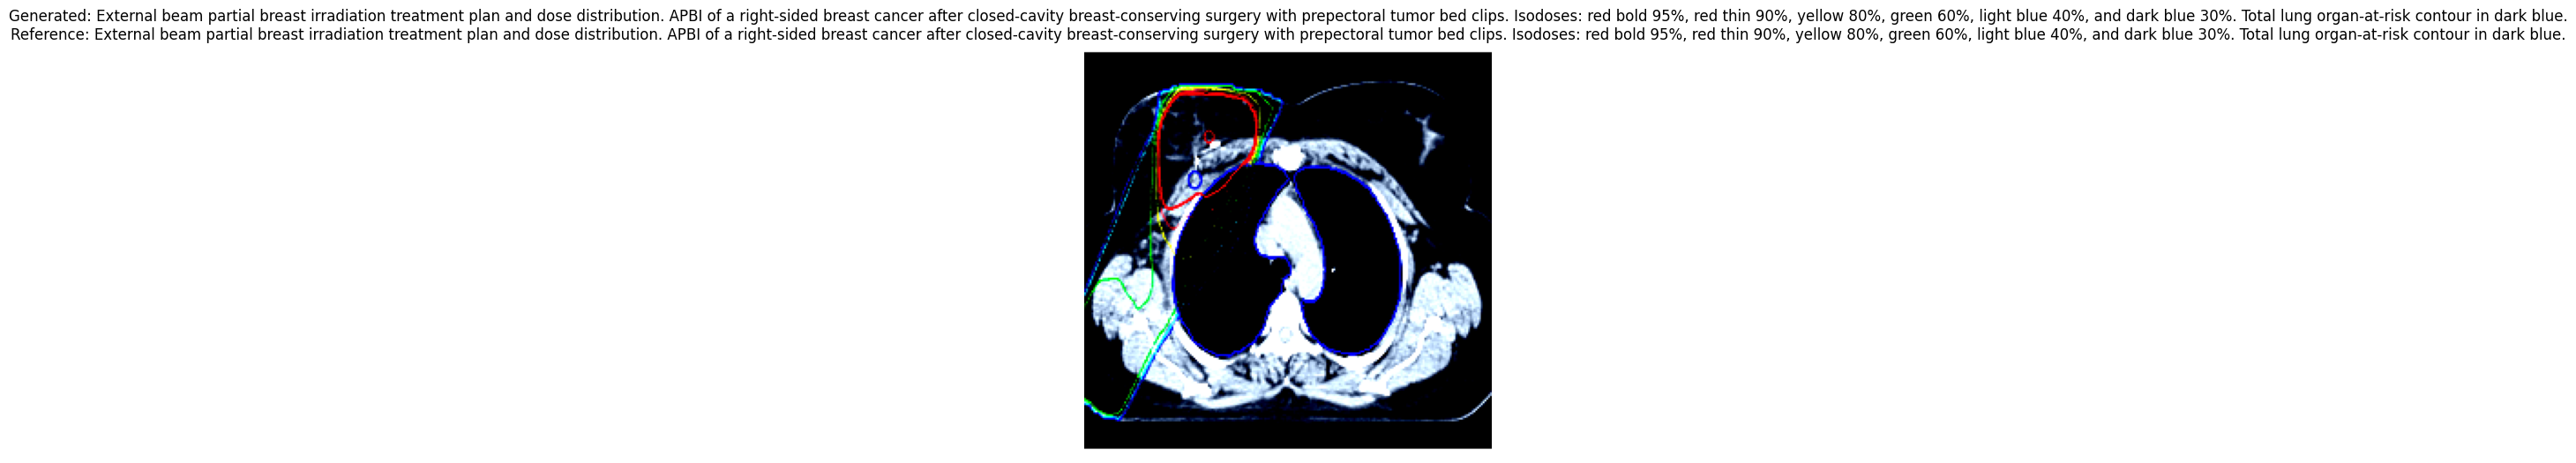

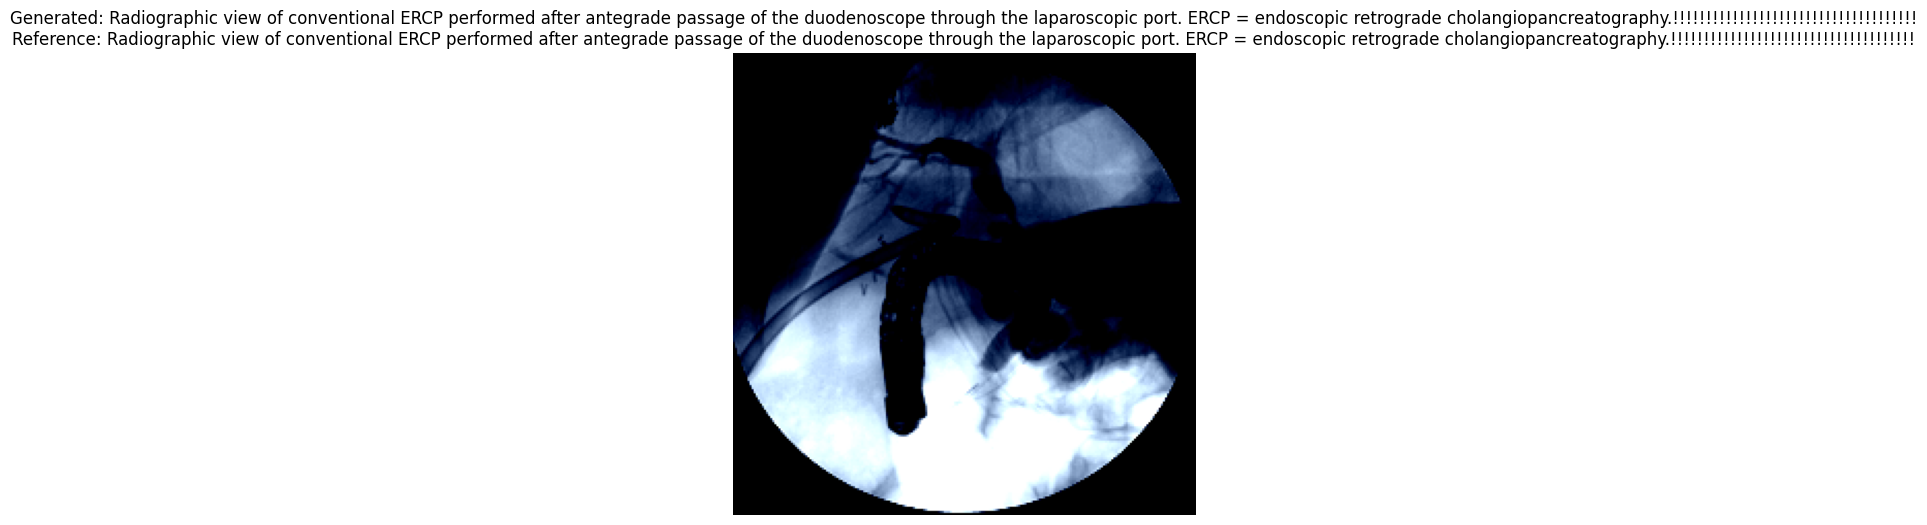

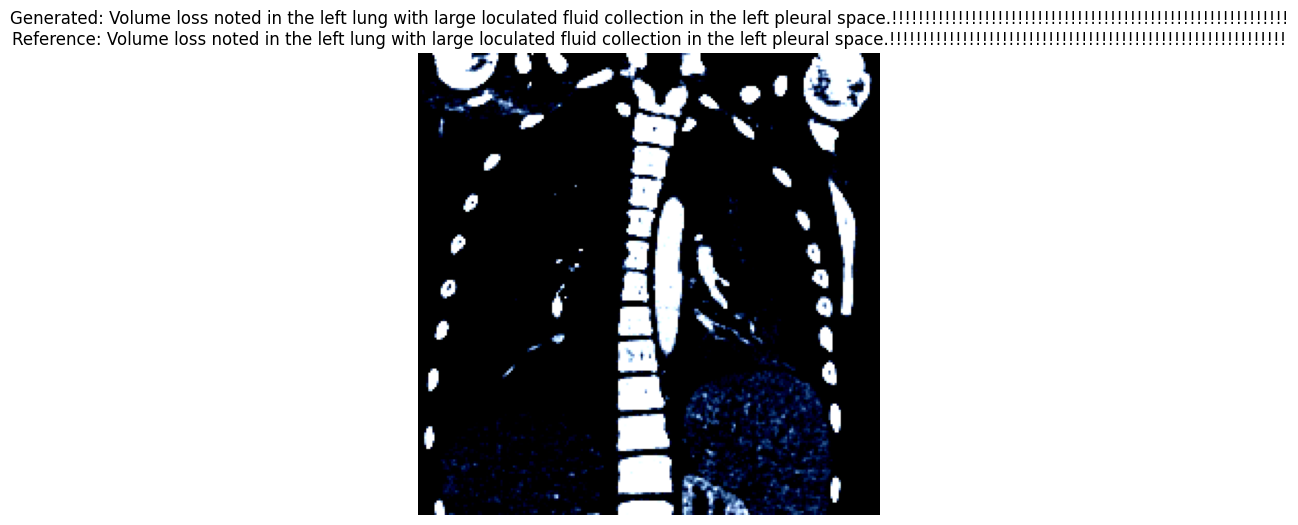

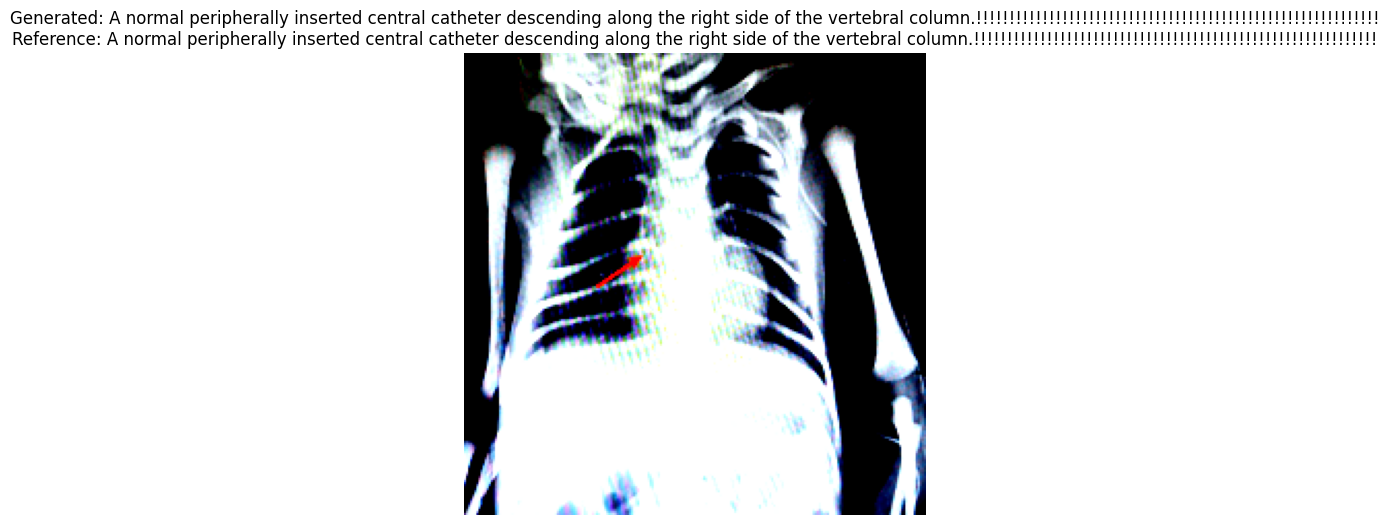

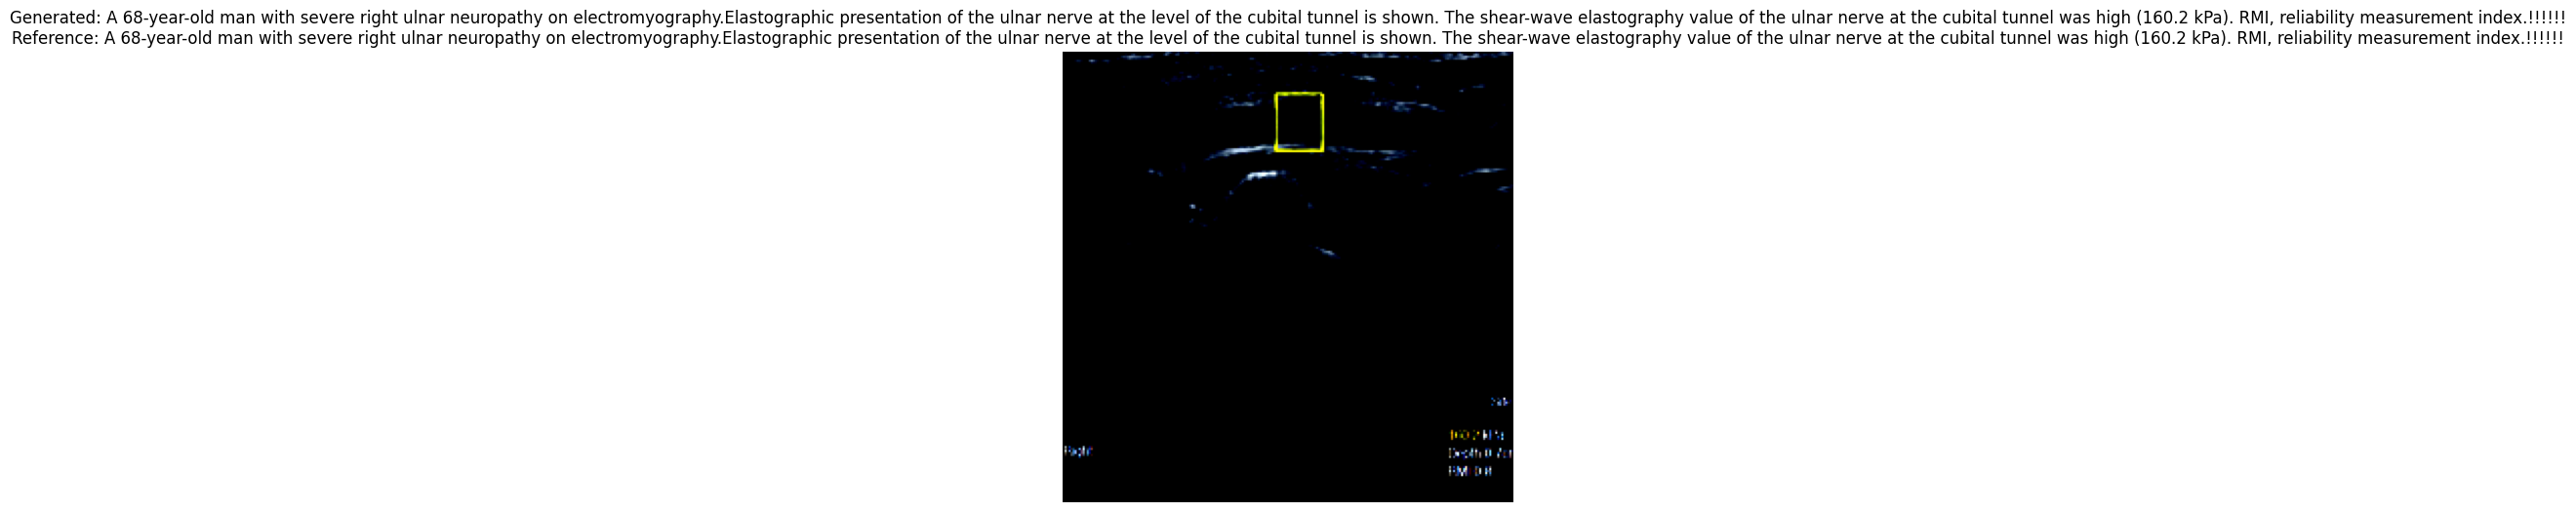

  0%|▏                                                                                                                                                                                                                                                                              | 1/1247 [00:12<4:23:25, 12.69s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


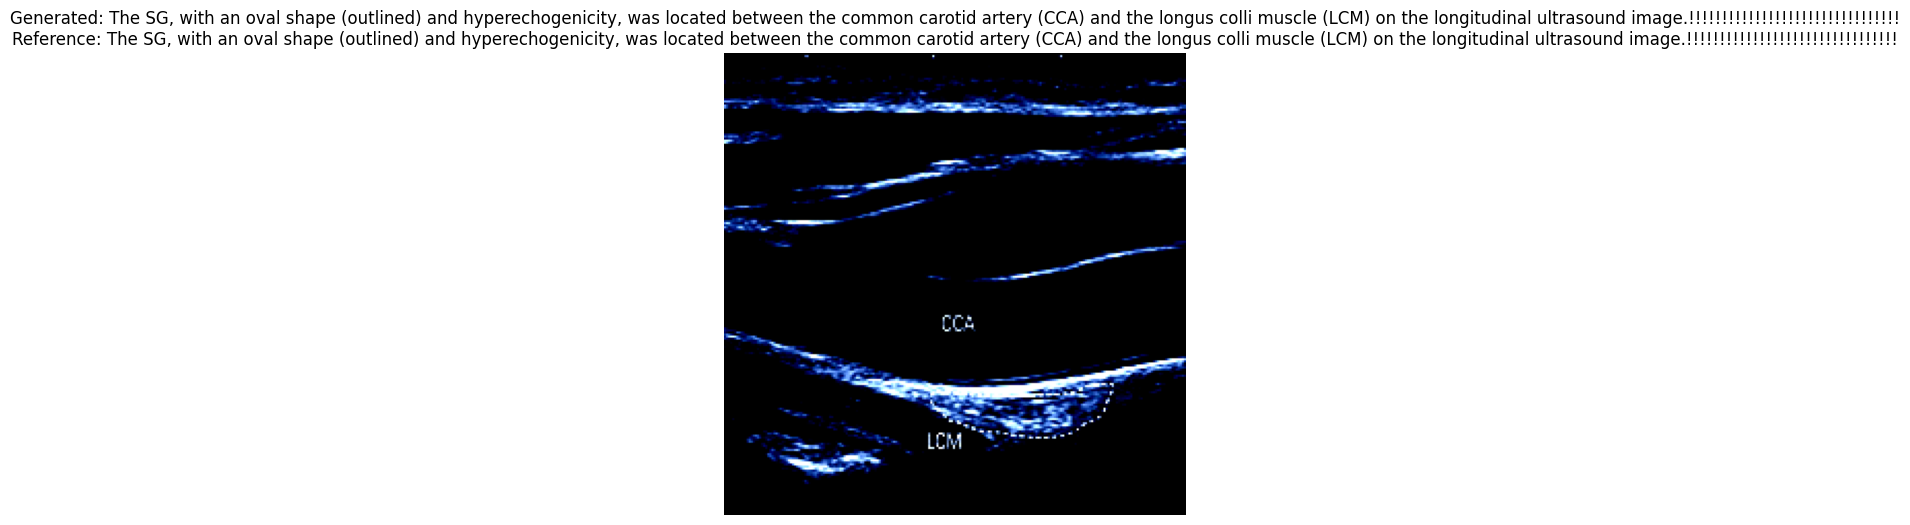

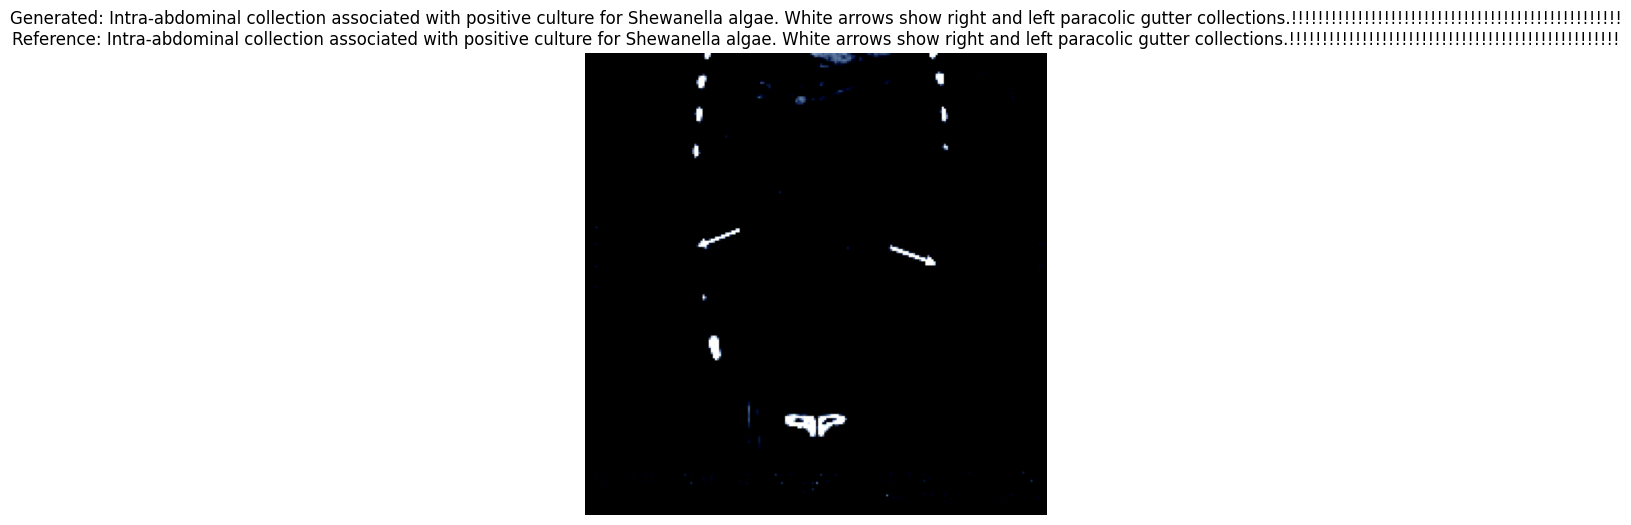

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1247/1247 [10:37<00:00,  1.96it/s]


Test Results: {'BLEU': 0.9894234064908655, 'GLEU': 0.999566902242367}


In [35]:
test_results = test_model(model, test_loader, metrics=['bleu', 'gleu'], num_examples=10, save_dir='generated_examples')

In [61]:
# Path to your image directory
image_dir = "../Datasets/MEDICAT SAMPLES/figures"  # Update this to the correct path

# Load the JSONL file
jsonl_file_path = '../Datasets/MEDICAT SAMPLES/sample.jsonl'

# Function to load JSONL data
def load_jsonl_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Load the samples from the JSONL file
data = load_jsonl_data(jsonl_file_path)

# Take the first 10 samples for inference
sample_data = data[:10]


In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model.to(device)

# Loop through the first 10 samples
for idx, sample in enumerate(sample_data):
    pdf_hash = sample['pdf_hash']  # Assuming 'pdf_hash' is in your sample data
    fig_uri = sample['fig_uri']
    image_path = f"{image_dir}/{pdf_hash}_{fig_uri}".replace('\\', '/')

    # Load and preprocess the image
    try:
        print(f"Running inference on: {image_path}")
        image = model.preprocess_image(image_path).to(device)  # Preprocess and add batch dimension
        
        # Generate caption using the model
        with torch.no_grad():
            caption = model.generate_caption_for_image(image)
        
        # Print the generated caption
        print(f"Caption {idx + 1}: {caption}\n")
    
    except FileNotFoundError:
        print(f"Image file not found: {image_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")


Running inference on: ../Datasets/MEDICAT SAMPLES/figures/26491ab76c6e8d6acc582e71bb6b3b5f5601ccc2_3-Figure4-1.png


In [77]:
def run_inference(model, sample_data, image_dir, num_examples=10, save_dir='generated_examples'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()  # Set the model to evaluation mode

    all_generated_captions = []
    examples_shown = 0

    # Create directory to save examples
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():  # Disable gradient calculation for inference
        for sample in sample_data:
            pdf_hash = sample['pdf_hash']  # Assuming 'pdf_hash' is in your sample data
            fig_uri = sample['fig_uri']
            image_path = f"{image_dir}/{pdf_hash}_{fig_uri}".replace('\\', '/')

            # Load the image
            image = Image.open(image_path).convert("RGB")  # Ensure the image is in RGB format

            # Use the model's preprocess method
            image_tensor = model.preprocess_val(image).unsqueeze(0).to(device)  # Preprocess image and add batch dimension

            # Extract image embeddings
            image_embeddings = model.encoder_model.encode_image(image_tensor)  # Get the image embeddings

            # Generate captions using GPT-2
            # Starting with the start token for GPT-2
            input_ids = model.gpt2_tokenizer.encode(model.gpt2_tokenizer.bos_token, return_tensors='pt').to(device)
            attention_mask = torch.ones(input_ids.shape, device=device)  # Create attention mask

            # Generate captions (modify max_length and other parameters as needed)
            output = model.gpt2_model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,  # Pass attention mask
                max_length=50,  # Adjust as needed
                num_return_sequences=1,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=1.0,
                pad_token_id=model.gpt2_tokenizer.eos_token_id  # Set pad token id
            )

            # Decode the generated token IDs to captions
            generated_caption = model.gpt2_tokenizer.decode(output[0], skip_special_tokens=True)
            all_generated_captions.append(generated_caption)

            # Show and save a few examples of predictions
            if examples_shown < num_examples:
                img_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy for displaying
                
                # Normalize the image for display
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0, 1]

                # Display the image and caption
                plt.figure(figsize=(8, 6))
                plt.imshow(img_np)
                plt.title(f"Generated: {generated_caption}")
                plt.axis('off')

                # Save the image with caption
                save_path = os.path.join(save_dir, f"example_{examples_shown + 1}.png")
                plt.savefig(save_path)
                plt.show()  # Show the image inline

                examples_shown += 1
                if examples_shown >= num_examples:
                    break

    return all_generated_captions


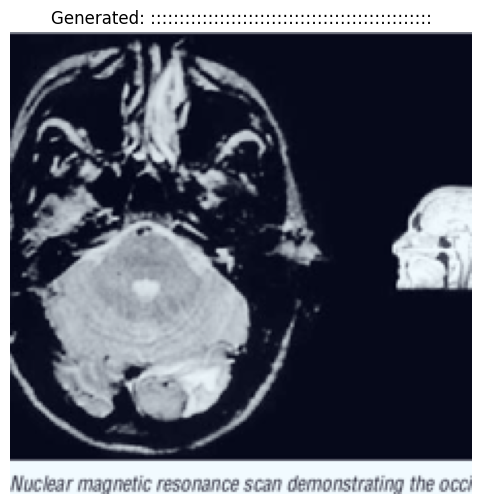

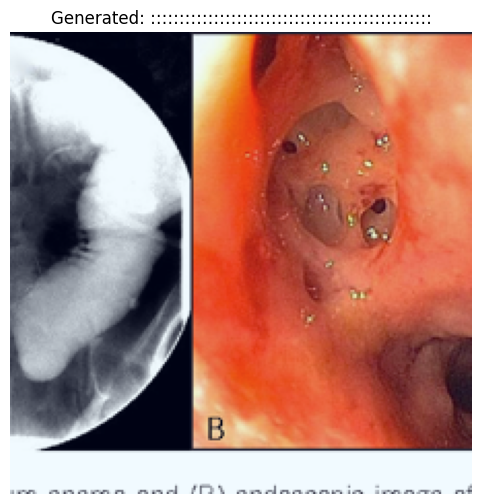

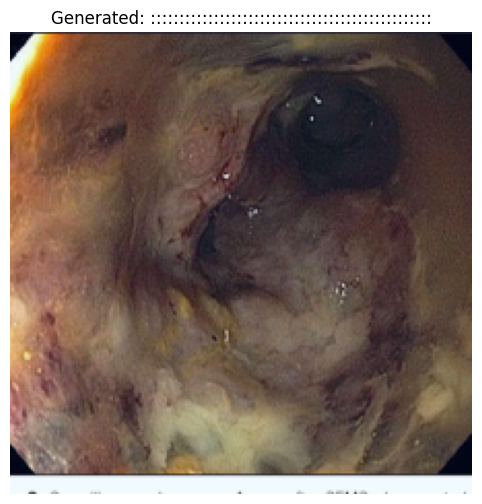

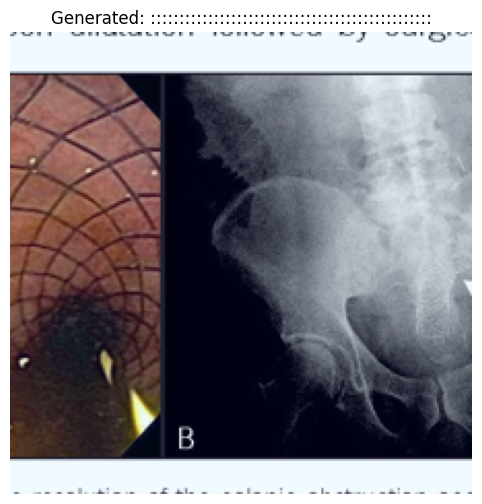

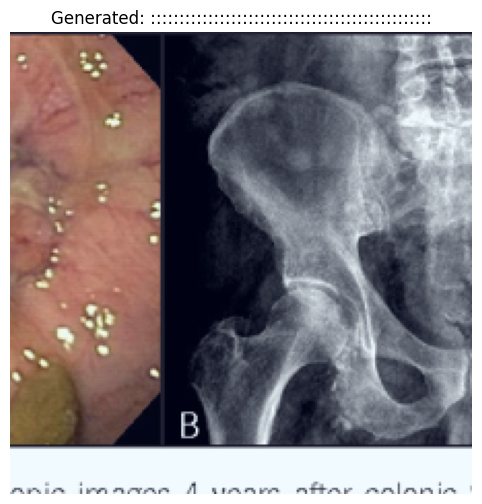

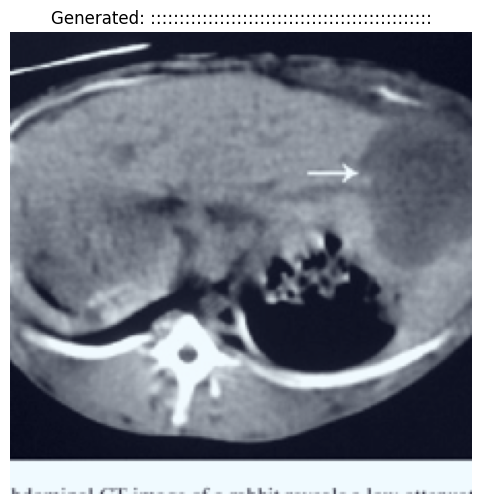

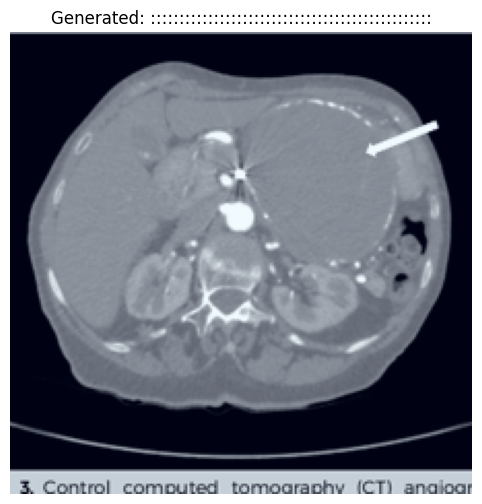

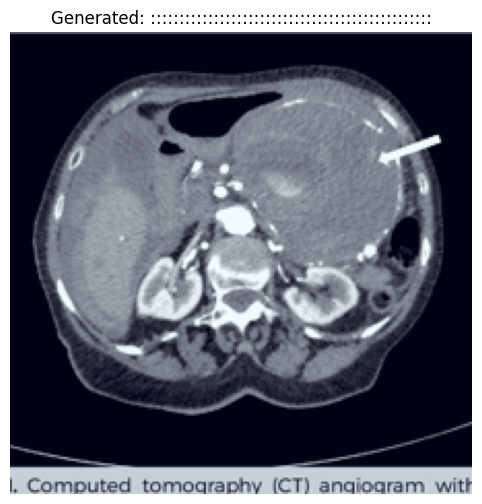

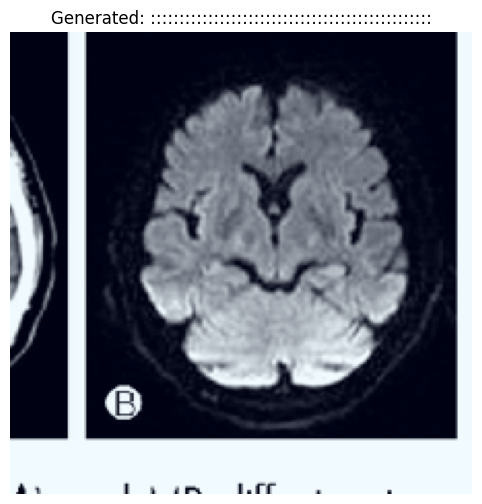

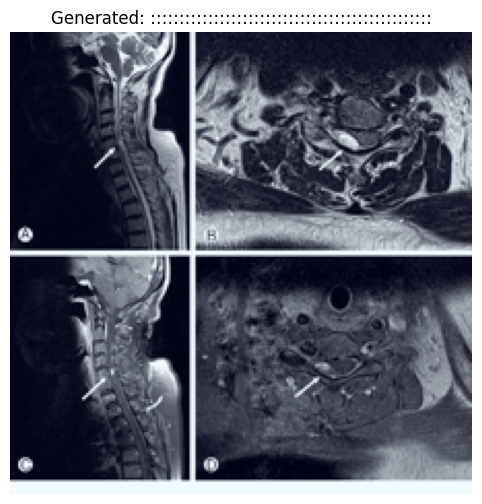

Generated Captions: [':::::::::::::::::::::::::::::::::::::::::::::::::', ':::::::::::::::::::::::::::::::::::::::::::::::::', ':::::::::::::::::::::::::::::::::::::::::::::::::', ':::::::::::::::::::::::::::::::::::::::::::::::::', ':::::::::::::::::::::::::::::::::::::::::::::::::', ':::::::::::::::::::::::::::::::::::::::::::::::::', ':::::::::::::::::::::::::::::::::::::::::::::::::', ':::::::::::::::::::::::::::::::::::::::::::::::::', ':::::::::::::::::::::::::::::::::::::::::::::::::', ':::::::::::::::::::::::::::::::::::::::::::::::::']


In [78]:
# Example usage
generated_captions = run_inference(model, sample_data, image_dir)  # No need to pass preprocess_func anymore
print("Generated Captions:", generated_captions)
